# <span style="color:red">ENSURE YOUR CODE RUNS WITHOUT ERRORS</span>
# Lab: Dimensionality Reduction and Clustering Techniques

## TAs: Ahmed Elshabrawy, Nada Saadi

### Introduction

This lab will help you understand the practical differences between various dimensionality reduction and clustering techniques. You'll implement several algorithms, visualize their results, and critically evaluate their performance on different datasets.

### Learning Objectives:

1. Implement and compare PCA, t-SNE, and K-means
2. Understand when to use different dimensionality reduction techniques
3. Evaluate clustering performance using internal and external metrics
4. Develop critical thinking about algorithm selection

In [1]:
FIRSTNAME = "Maosheng"
LASTNAME = "Li"

In [2]:
# turn warnings off
import warnings
warnings.filterwarnings('ignore')

## Install Dependencies if you need to

In [3]:
# !pip install numpy pandas matplotlib seaborn scikit-learn scipy tensorflow

## Setup and Configuration

In [4]:
# Set all random seeds for reproducibility
import numpy as np
import random

SEED=42

# <<<<<<<<<<<<<<<<<< Your Code Here >>>>>>>>>>>>>>>>>>

random.seed(SEED)
np.random.seed(SEED)

# <<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>

# Import libraries
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

print("All libraries imported and random seeds set!")

All libraries imported and random seeds set!


## Part 1: Data Preparation

### Exercise 1.1: Generate and Validate Synthetic Datasets

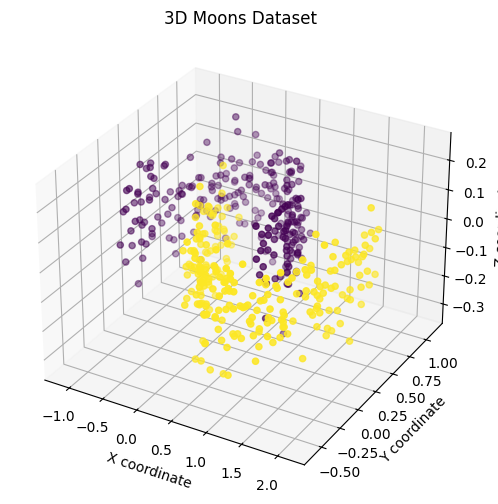

In [5]:
def generate_and_validate_datasets():
    """
    Generate three different synthetic datasets with specific properties
    """
    # Dataset 1: Well-separated spherical clusters with 100 dimensions, 500 samples, 4 clusters

    # <<<<<<<<<<<<<<<<<< Your Code Here >>>>>>>>>>>>>>>>>>

    X1, y1 = make_blobs(
        n_samples=500,
        centers=4,
        n_features=100,
        cluster_std=0.6,
    )

    # <<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>

    # Dataset 2: Non-spherical clusters (swiss roll)

    # <<<<<<<<<<<<<<<<<< Your Code Here >>>>>>>>>>>>>>>>>>

    # Generate the 2D moon-shaped data with 500 samples and 0.07 noise
    X2_2d, y2 = make_moons(n_samples=500, noise=0.07)

    # Add a third dimension with Gaussian noise (0 mean, 0.1 std) (i.e. the third dimension is just noise to create a 3D dataset)
    z_noise = np.random.normal(loc=0.0, scale=0.1, size=(500, 1))
    X2 = np.hstack([X2_2d, z_noise])

    # <<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>

    # Visualize the 3D data
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X2[:, 0], X2[:, 1], X2[:, 2], c=y2, cmap='viridis', marker='o')

    ax.set_title("3D Moons Dataset")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    ax.set_zlabel("Z coordinate")
    plt.show()

    # Dataset 3: High-dimensional data (digits)
    # Use only 3 classes (0, 1, 2) for simplicity and balance the classes
    # Ensure we have the same number of samples for each class by downsampling to the smallest class size

    # <<<<<<<<<<<<<<<<<< Your Code Here >>>>>>>>>>>>>>>>>>

    digits = load_digits()
    Xd, yd = digits.data, digits.target

    keep_classes = [0, 1, 2]
    mask = np.isin(yd, keep_classes)
    Xd, yd = Xd[mask], yd[mask]

    min_count = min((yd == c).sum() for c in keep_classes)
    idx_list = []
    for c in keep_classes:
        idx_c = np.where(yd == c)[0]
        np.random.shuffle(idx_c)
        idx_list.append(idx_c[:min_count])
    sel_idx = np.concatenate(idx_list)
    np.random.shuffle(sel_idx)

    X3, y3 = Xd[sel_idx], yd[sel_idx]

    # <<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>

    datasets = [
        (X1, y1, "Spherical Clusters", {'n_clusters': 4, 'cluster_std': 0.6}),
        (X2, y2, "Non-spherical Clusters", {'n_clusters': 2, 'noise': 0.1}),
        (X3, y3, "Digits Data", {'n_classes': 3, 'n_features': 64})
    ]

    return datasets

# Generate datasets
datasets = generate_and_validate_datasets()

## Part 2: Dimensionality Reduction Comparison

### Exercise 2.1: Implement and Validate Dimensionality Reduction

In [6]:
def apply_dimensionality_reduction(X, y, dataset_name):
    """
    Apply PCA and t-SNE with validation and multiple structure-preservation metrics.

    Metrics:
    - PCA variance ratio: how much variance in the data is captured by the 2D PCA projection (global).
    - Distance correlation (Pearson, Spearman): correlation between pairwise distances
      in high-D vs low-D (global structure).
    - Trustworthiness: how well local neighborhoods in high-D are preserved in low-D (local).
    - kNN overlap: fraction of preserved nearest neighbors (local).
    """

    # ---------- Preprocessing ----------
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # ---------- PCA ----------

    # <<<<<<<<<<<<<<<<<< Your Code Here >>>>>>>>>>>>>>>>>>
    pca = PCA(n_components=2, svd_solver='full')
    X_pca = pca.fit_transform(X_scaled)

    # <<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>

    assert X_pca.shape == (X.shape[0], 2), "PCA should output 2D data"
    assert not np.isnan(X_pca).any(), "PCA output contains NaN values"

    # ---------- t-SNE ----------
    # USE A REASONABLE PERPLEXITY BASED ON DATASET SIZE (e.g. between 5 and 50)
    # EXPERIMENT WITH DIFFERENT PERLPLEXITIES BASED ON THE METRICS YOU SEE PRINTED FROM THIS CELL AND TRY TO MAXIMIZE THEM

    # <<<<<<<<<<<<<<<<<< Your Code Here >>>>>>>>>>>>>>>>>>
    n = X.shape[0]
    recommended = max(5, min(50, int((n - 1) / 3)))
    perplexity = recommended

    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        init='pca',
        learning_rate='auto',
        n_iter=1000,
    )
    X_tsne = tsne.fit_transform(X_scaled)

    # <<<<<<<<<<<<<<<<<<<<>>>>>>>>>>>>>>>>>>>>

    assert X_tsne.shape == (X.shape[0], 2), "t-SNE should output 2D data"
    assert not np.isnan(X_tsne).any(), "t-SNE output contains NaN values"

    # ---------- Metrics ----------

    ## 1. PCA variance ratio (global structure / variance preservation)
    pca_variance_ratio = pca.explained_variance_ratio_.sum()

    ## 2. Distance preservation (global structure)
    original_distances = pdist(X_scaled)
    pca_distances = pdist(X_pca)
    tsne_distances = pdist(X_tsne)

    # Pearson correlation: linear correlation of distances
    distance_corr_pca = np.corrcoef(original_distances, pca_distances)[0, 1]
    distance_corr_tsne = np.corrcoef(original_distances, tsne_distances)[0, 1]

    # Spearman correlation: rank-order correlation of distances
    spearman_corr_pca = spearmanr(original_distances, pca_distances).correlation
    spearman_corr_tsne = spearmanr(original_distances, tsne_distances).correlation

    ## 3. Trustworthiness (local structure preservation)
    trust_pca = trustworthiness(X_scaled, X_pca, n_neighbors=10)
    trust_tsne = trustworthiness(X_scaled, X_tsne, n_neighbors=10)

    ## 4. kNN overlap (local structure preservation)
    def knn_overlap(X_high, X_low, k=10):
        nbrs_h = NearestNeighbors(n_neighbors=k+1).fit(X_high)
        nbrs_l = NearestNeighbors(n_neighbors=k+1).fit(X_low)
        idx_h = nbrs_h.kneighbors(return_distance=False)[:, 1:]
        idx_l = nbrs_l.kneighbors(return_distance=False)[:, 1:]
        overlaps = [len(np.intersect1d(a, b)) / k for a, b in zip(idx_h, idx_l)]
        return np.mean(overlaps)

    knn_pca = knn_overlap(X_scaled, X_pca, k=10)
    knn_tsne = knn_overlap(X_scaled, X_tsne, k=10)

    return {
        'X_pca': X_pca,
        'X_tsne': X_tsne,
        'pca_variance_ratio': pca_variance_ratio,
        'distance_corr_pca': distance_corr_pca,
        'distance_corr_tsne': distance_corr_tsne,
        'spearman_corr_pca': spearman_corr_pca,
        'spearman_corr_tsne': spearman_corr_tsne,
        'trust_pca': trust_pca,
        'trust_tsne': trust_tsne,
        'knn_pca': knn_pca,
        'knn_tsne': knn_tsne,
        'pca_model': pca
    }

# Apply dimensionality reduction and compute metrics for each dataset
dr_results = {}
for X, y, name, params in datasets:
    dr_results[name] = apply_dimensionality_reduction(X, y, name)
    print(f"Dimensionality reduction applied to {name}")
    print(f"PCA Variance Ratio: {dr_results[name]['pca_variance_ratio']:.4f}")
    print(f"Distance Correlation (PCA): {dr_results[name]['distance_corr_pca']:.4f}, (t-SNE): {dr_results[name]['distance_corr_tsne']:.4f}")
    print(f"Spearman Correlation (PCA): {dr_results[name]['spearman_corr_pca']:.4f}, (t-SNE): {dr_results[name]['spearman_corr_tsne']:.4f}")
    print(f"Trustworthiness (PCA): {dr_results[name]['trust_pca']:.4f}, (t-SNE): {dr_results[name]['trust_tsne']:.4f}")
    print(f"kNN Overlap (PCA): {dr_results[name]['knn_pca']:.4f}, (t-SNE): {dr_results[name]['knn_tsne']:.4f}")
    print("-" * 50)

Dimensionality reduction applied to Spherical Clusters
PCA Variance Ratio: 0.6912
Distance Correlation (PCA): 0.8749, (t-SNE): 0.9399
Spearman Correlation (PCA): 0.8224, (t-SNE): 0.7888
Trustworthiness (PCA): 0.9056, (t-SNE): 0.9631
kNN Overlap (PCA): 0.1140, (t-SNE): 0.3076
--------------------------------------------------
Dimensionality reduction applied to Non-spherical Clusters
PCA Variance Ratio: 0.8131
Distance Correlation (PCA): 0.9282, (t-SNE): 0.7106
Spearman Correlation (PCA): 0.9255, (t-SNE): 0.7378
Trustworthiness (PCA): 0.9100, (t-SNE): 0.9980
kNN Overlap (PCA): 0.3888, (t-SNE): 0.8136
--------------------------------------------------
Dimensionality reduction applied to Digits Data
PCA Variance Ratio: 0.3903
Distance Correlation (PCA): 0.5425, (t-SNE): 0.4185
Spearman Correlation (PCA): 0.7708, (t-SNE): 0.5971
Trustworthiness (PCA): 0.8891, (t-SNE): 0.9746
kNN Overlap (PCA): 0.2264, (t-SNE): 0.5102
--------------------------------------------------


### Exercise 2.2: Multiple Choice Questions - Dimensionality Reduction

In [7]:
# Multiple Choice Questions with automated grading
def dimensionality_reduction_mcqs():
    """
    Answer these MCQs based on your implementation and results
    """
    questions = [
        {
            'question': 'Which dimensionality reduction technique generally preserves global structure better?',
            'options': ['PCA', 't-SNE', 'Both preserve global structure equally well', 'Neither preserves global structure'],
        },
        {
            'question': 't-SNE is particularly good at preserving:',
            'options': ['Global distances between clusters', 'Local neighborhoods and non-linear relationships', 'Variance in the original data', 'All of the above'],
        },
        {
            'question': 'When working with high-dimensional data like the digits dataset, which technique typically shows better cluster separation in 2D?',
            'options': ['PCA', 't-SNE', 'They perform equally well', 'Neither technique works well'],
        },
        {
            'question': 'The explained variance ratio in PCA represents:',
            'options': ['The percentage of total variance captured by each component', 'The accuracy of the dimensionality reduction', 'The distance between clusters in reduced space', 'The computational efficiency of PCA'],
        }
    ]

    return questions

# Test with sample answers (students will replace this)
dr_questions = dimensionality_reduction_mcqs()
print("=== Dimensionality Reduction MCQs ===")
for q in dr_questions:
    print('Question:', q['question'])
    print('\tOptions:')
    for option in q['options']:
        print('\t -', option)
# <<<<<<<<<<<<<<<<<< Fill in Here >>>>>>>>>>>>>>>>>>
sample_student_answers = ['PCA','Local neighborhoods and non-linear relationships','t-SNE','The percentage of total variance captured by each component',]  # Students will replace this with their answers
print(sample_student_answers)

=== Dimensionality Reduction MCQs ===
Question: Which dimensionality reduction technique generally preserves global structure better?
	Options:
	 - PCA
	 - t-SNE
	 - Both preserve global structure equally well
	 - Neither preserves global structure
Question: t-SNE is particularly good at preserving:
	Options:
	 - Global distances between clusters
	 - Local neighborhoods and non-linear relationships
	 - Variance in the original data
	 - All of the above
Question: When working with high-dimensional data like the digits dataset, which technique typically shows better cluster separation in 2D?
	Options:
	 - PCA
	 - t-SNE
	 - They perform equally well
	 - Neither technique works well
Question: The explained variance ratio in PCA represents:
	Options:
	 - The percentage of total variance captured by each component
	 - The accuracy of the dimensionality reduction
	 - The distance between clusters in reduced space
	 - The computational efficiency of PCA
['PCA', 'Local neighborhoods and non-lin

## Part 3: Clustering Algorithms

### Exercise 3.1: Implement and Validate Clustering Methods

In [8]:
def implement_clustering_algorithms(X, y_true, n_clusters):
    """
    Implement and validate multiple clustering algorithms
    """
    X_scaled = StandardScaler().fit_transform(X)
    # Define clustering algorithms: KMeans, Agglomerative, GMM, SpectralClustering
    # be careful with spectral clustering parameters (e.g. n_neighbors) make sure they make sense

    algorithms = {
        # <<<<<<<<<<<<<<<<<< Your Code Here >>>>>>>>>>>>>>>>>>
        'KMeans': KMeans(
                n_clusters=n_clusters,
                random_state=SEED,
                n_init=10),
        'Agglomerative':AgglomerativeClustering(
                n_clusters=n_clusters,
                linkage='ward'),
        'GMM': GaussianMixture(
                n_components=n_clusters,
                covariance_type='full',
                random_state=SEED,
                n_init=5),
        'Spectral':SpectralClustering(
                n_clusters=n_clusters,
                affinity='nearest_neighbors',
                n_neighbors=10,
                assign_labels='kmeans',
                random_state=SEED),
        # <<<<<<<<<<<<<<<<<< Your Code Here >>>>>>>>>>>>>>>>>>
    }

    results = {}

    for name, algo in algorithms.items():
        try:
            # Fit and predict
            if hasattr(algo, 'fit_predict'):
                y_pred = algo.fit_predict(X_scaled)
            else:
                y_pred = algo.fit(X_scaled).predict(X_scaled)

            # Validate predictions
            assert len(y_pred) == len(y_true), "Prediction length mismatch"
            assert len(np.unique(y_pred)) == n_clusters, f"{name}: Expected {n_clusters} clusters, got {len(np.unique(y_pred))}"

            # Calculate metrics
            silhouette = silhouette_score(X_scaled, y_pred)
            ari = adjusted_rand_score(y_true, y_pred)
            calinski = calinski_harabasz_score(X_scaled, y_pred)

            # Validate metrics
            assert -1 <= silhouette <= 1, "Silhouette score out of range"
            assert -0.1 <= ari <= 1.1, "ARI out of reasonable range"

            results[name] = {
                'labels': y_pred,
                'silhouette': silhouette,
                'ari': ari,
                'calinski': calinski,
                'n_clusters_found': len(np.unique(y_pred))
            }

        except Exception as e:
            print(f"Error with {name}: {e}")
            results[name] = None

    return results

# Apply clustering to all datasets
clustering_results = []

print("=== Applying Clustering Algorithms ===")
for i, (X, y, name, params) in enumerate(datasets):
    print(f"\nClustering {name}...")
    n_clusters = params.get('n_clusters', params.get('n_classes', 3))
    results = implement_clustering_algorithms(X, y, n_clusters)
    clustering_results.append(results)

    for algo_name, metrics in results.items():
        if metrics:
            print(f"  {algo_name}: Silhouette={metrics['silhouette']:.3f}, ARI={metrics['ari']:.3f}")

=== Applying Clustering Algorithms ===

Clustering Spherical Clusters...
  KMeans: Silhouette=0.869, ARI=1.000
  Agglomerative: Silhouette=0.869, ARI=1.000
  GMM: Silhouette=0.869, ARI=1.000
  Spectral: Silhouette=0.869, ARI=1.000

Clustering Non-spherical Clusters...
  KMeans: Silhouette=0.354, ARI=0.467
  Agglomerative: Silhouette=0.330, ARI=0.583
  GMM: Silhouette=0.354, ARI=0.489
  Spectral: Silhouette=0.279, ARI=0.976

Clustering Digits Data...
  KMeans: Silhouette=0.255, ARI=0.766
  Agglomerative: Silhouette=0.255, ARI=0.812
  GMM: Silhouette=0.255, ARI=0.766
  Spectral: Silhouette=0.255, ARI=0.812


### Exercise 3.2: Multiple Choice Questions - Clustering

In [12]:
def clustering_mcqs():
    """
    Multiple choice questions about clustering algorithms including spectral clustering
    """
    questions = [
        {
            'question': 'Which clustering algorithm assumes spherical clusters and uses centroid-based approach?',
            'options': ['K-means', 'Agglomerative Clustering', 'Gaussian Mixture Models', 'DBSCAN'],
        },
        {
            'question': 'The Silhouette Score measures:',
            'options': [
                'How well clusters are separated and how compact they are',
                'The accuracy compared to true labels',
                'The variance within clusters',
                'The distance between cluster centers'
            ],
        },
        {
            'question': 'Which algorithm performed best on non-spherical clusters (swiss roll data) in your experiments?',
            'options': ['K-means', 'Agglomerative Clustering', 'Gaussian Mixture Models', 'All performed equally'],
        },
        {
            'question': 'Gaussian Mixture Models differ from K-means in that they:',
            'options': [
                'Assume clusters have Gaussian distributions',
                'Use soft assignments allowing points to belong to multiple clusters',
                'Can handle non-spherical clusters',
                'All of the above'
            ],
        },
        {
            'question': 'The Adjusted Rand Index (ARI) requires:',
            'options': [
                'True labels for comparison',
                'Only the clustered data',
                'Pre-defined number of clusters',
                'Normalized input data'
            ],
        },
        {
            'question': 'Spectral clustering works by:',
            'options': [
                'Finding centroids that minimize within-cluster variance',
                'Performing clustering on a lower-dimensional embedding of the affinity matrix',
                'Merging the closest clusters iteratively',
                'Modeling clusters as Gaussian distributions'
            ],
        },
        {
            'question': 'Which of the following is a key advantage of spectral clustering?',
            'options': [
                'It is very fast for large datasets',
                'It can identify clusters of arbitrary shapes',
                'It always converges to the global optimum',
                'It does not require specifying the number of clusters'
            ],
        },
        {
            'question': 'In spectral clustering, the affinity matrix represents:',
            'options': [
                'The distance between cluster centroids',
                'The pairwise similarities between data points',
                'The variance within each cluster',
                'The eigenvalues of the data covariance matrix'
            ],
        },
        {
            'question': 'Which statement about spectral clustering is FALSE?',
            'options': [
                'It can be computationally expensive for large datasets',
                'It requires specifying the number of clusters in advance',
                'It is sensitive to the choice of similarity metric',
                'It always produces convex clusters'
            ],
        },
        {
            'question': 'When would you choose spectral clustering over K-means?',
            'options': [
                'When you have spherical clusters and need fast computation',
                'When you have complex-shaped clusters and computational cost is not a concern',
                'When you have labeled data for supervised learning',
                'When you need to cluster very high-dimensional text data'
            ],
        }
    ]

    return questions

print("=== Clustering MCQs (including Spectral Clustering) ===")
clustering_questions = clustering_mcqs()
for q in clustering_questions:
    print('Question:', q['question'])
    print('\tOptions:')
    for option in q['options']:
        print('\t -', option)

# <<<<<<<<<<<<<<<<<< Fill in Here >>>>>>>>>>>>>>>>>>
sample_answers = [
    'K-means',
    'How well clusters are separated and how compact they are',
    'Agglomerative Clustering better(option); but best is Spectral',
    'All of the above',
    'True labels for comparison',
    'Performing clustering on a lower-dimensional embedding of the affinity matrix',
    'It can identify clusters of arbitrary shapes',
    'The pairwise similarities between data points',
    'It always produces convex clusters',
    'When you have complex-shaped clusters and computational cost is not a concern',
]  # Students will replace this

=== Clustering MCQs (including Spectral Clustering) ===
Question: Which clustering algorithm assumes spherical clusters and uses centroid-based approach?
	Options:
	 - K-means
	 - Agglomerative Clustering
	 - Gaussian Mixture Models
	 - DBSCAN
Question: The Silhouette Score measures:
	Options:
	 - How well clusters are separated and how compact they are
	 - The accuracy compared to true labels
	 - The variance within clusters
	 - The distance between cluster centers
Question: Which algorithm performed best on non-spherical clusters (swiss roll data) in your experiments?
	Options:
	 - K-means
	 - Agglomerative Clustering
	 - Gaussian Mixture Models
	 - All performed equally
Question: Gaussian Mixture Models differ from K-means in that they:
	Options:
	 - Assume clusters have Gaussian distributions
	 - Use soft assignments allowing points to belong to multiple clusters
	 - Can handle non-spherical clusters
	 - All of the above
Question: The Adjusted Rand Index (ARI) requires:
	Options:
	